In [1]:
# This notebook contasins the code to differentiate images based on sports

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [3]:
from os import listdir
import wget

## Loading the data

In [43]:
PATH = "/home/ubuntu/datasets/sports_images/"
sz=224

In [44]:
files = listdir(f'{PATH}train/baseball')[:5]
files

['bs36.jpg', 'bs37.jpg', 'bs5.jpg', 'bs21.jpg', 'bs39.jpeg']

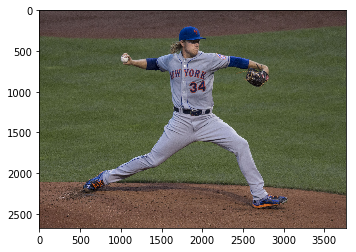

In [45]:
img = plt.imread(f'{PATH}train/baseball/{files[0]}')
plt.imshow(img);

The numbers above mean the image has 304*493 pixels with 3 channels (R, G, and B)

In [7]:
img.shape

(2672, 3763, 3)

Lets verify it using img.size function

In [8]:
img.size

30164208

In [9]:
304*493*3

449616

Let's have a look at what type of numbers are stored by selecting first 4 rows and columns.

In [10]:
img[:4,:4]

array([[[88, 74, 74],
        [86, 72, 72],
        [78, 64, 64],
        [73, 59, 59]],

       [[88, 74, 74],
        [87, 73, 73],
        [83, 69, 69],
        [79, 65, 65]],

       [[84, 70, 70],
        [86, 72, 72],
        [85, 71, 71],
        [83, 69, 69]],

       [[81, 67, 67],
        [83, 69, 69],
        [85, 71, 71],
        [83, 69, 69]]], dtype=uint8)

## Building a simple model

We're going to use a pre-trained model, that is, a model created by someone else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision.

### Download pre-trained models

I used the following links to download the model

    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth'

In [10]:
url = "https://download.pytorch.org/models/resnet152-b121ed2d.pth"
wget.download(url, '/home/ubuntu/pretrained_models/')

'/home/ubuntu/pretrained_models//resnet152-b121ed2d.pth'

Lets check the size of each model

In [14]:
!ls -l --block-size=M /home/ubuntu/pretrained_models/

total 499M
-rw-rw-r-- 1 ubuntu ubuntu 171M Jan  9 19:12 resnet101-5d3b4d8f.pth
-rw-r--r-- 1 ubuntu ubuntu 231M Jan  9 19:17 resnet152-b121ed2d.pth
-rw-rw-r-- 1 ubuntu ubuntu  98M Jan  9 19:11 resnet50-19c8e357.pth


As you can see above, when the number of number of layers double the pre-trained models also double in size.

Another simple way is to just import it from torchvision

In [12]:
from torchvision.models import resnet18
from torchvision.models import resnet34

In [12]:
# We are using pre-trained model called resnet34
arch=resnet34
# and then use arch as parameter

If you wish to check all available pretrained models:

In [11]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'Inception3',
 'ResNet',
 'SqueezeNet',
 'VGG',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'inception',
 'inception_v3',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

### Data Preprocessing

In [51]:
# from torchvision import transforms
# transform_for_sports_data = transforms.Compose([            
#  transforms.Resize(256),                    # Resize the image to 256×256 pixels.
#  transforms.CenterCrop(224),                # Crop the image to 224×224 pixels about the center.
#  transforms.RandomHorizontalFlip(),          # As these are sports images lets do only horrizonal flip
#  transforms.ToTensor(),                     # Convert the image to PyTorch Tensor data type.
#  transforms.Normalize(                      # Normalize the image by setting its mean and standard deviation to the specified values.
#  mean=[0.485, 0.456, 0.406],            
#  std=[0.229, 0.224, 0.225]                  
#  )])

List of all transforms here:

https://pytorch.org/docs/stable/torchvision/transforms.html

In [13]:
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

In [52]:
# train_loader = torch.utils.data.DataLoader(
#     torchvision.datasets.ImageFolder(PATH, transform=transform_for_sports_data),
#     batch_size=4,
#     num_workers=0,
#     shuffle=True)

In [53]:
# train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 60
    Root Location: /home/ubuntu/datasets/sports_images/
    Transforms (if any): Compose(
                             Resize(size=256, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [54]:
# dataiter = iter(train_loader)   # provided one batch at a time
# images = dataiter.next()        # as per the batch size (bs) 4 images are pulled along with their labels

In [55]:
# len(images)

2

In [58]:
# len(images[0]),len(images[1])

(4, 4)

In [61]:
# images[1]

tensor([0, 1, 1, 0])

In [15]:
# im1 = images[0][0]
# type(im1), im1.shape

In [67]:
# images[0][0]

tensor([[[-1.9295, -1.8782, -1.8439,  ..., -1.9295, -1.9295, -1.9295],
         [-1.9467, -1.8782, -1.8610,  ..., -1.9295, -1.9124, -1.9124],
         [-1.9295, -1.9124, -1.8953,  ..., -1.9467, -1.9295, -1.9124],
         ...,
         [-0.0801, -0.0116,  0.0741,  ...,  0.3652,  0.3138,  0.1254],
         [ 0.0056,  0.0569, -0.1143,  ...,  0.3994,  0.0569, -0.2513],
         [-0.3883, -0.4226, -0.5938,  ...,  0.0741,  0.1597,  0.2796]],

        [[-1.7906, -1.7381, -1.7031,  ..., -1.8431, -1.8431, -1.8431],
         [-1.8081, -1.7381, -1.7206,  ..., -1.8606, -1.8431, -1.8431],
         [-1.7731, -1.7556, -1.7381,  ..., -1.8782, -1.8606, -1.8431],
         ...,
         [-0.4076, -0.3200, -0.2500,  ..., -0.0574, -0.1099, -0.3025],
         [-0.3375, -0.2850, -0.4601,  ...,  0.0301, -0.3375, -0.6352],
         [-0.7752, -0.8102, -0.9853,  ..., -0.3025, -0.2150, -0.0924]],

        [[-1.4384, -1.3861, -1.3513,  ..., -1.5604, -1.5604, -1.5604],
         [-1.4559, -1.3861, -1.3687,  ..., -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


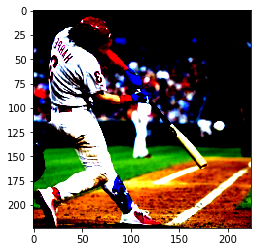

In [75]:
# plt.imshow(im1.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


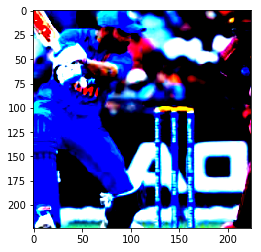

In [76]:
# im1 = images[0][1]
# plt.imshow(im1.permute(1, 2, 0))

## PyTorch tutorial code

In [14]:
from torchvision import datasets, models, transforms
import os

In [73]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [74]:
data_dir = '/home/ubuntu/datasets/sports_images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [75]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [76]:
len(dataloaders), type(dataloaders)

(2, dict)

In [77]:
dataloaders.items()

dict_items([('train', <torch.utils.data.dataloader.DataLoader object at 0x7f9744143cc0>), ('val', <torch.utils.data.dataloader.DataLoader object at 0x7f97441434a8>)])

In [51]:
len(dataloaders['train']), len(dataloaders['val'])

(36, 16)

In [52]:
dataloaders['val'].dataset.imgs

[('/home/ubuntu/datasets/sports_images/val/baseball/bs41.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs42.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs43.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs44.jpeg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs45.JPG', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs46.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs47.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs48.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs49.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs50.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs51.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs52.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs53.jpg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs54.jpeg', 0),
 ('/home/ubuntu/datasets/sports_images/val/baseball/bs55.jpg

In [53]:
dataloaders['val'].dataset.transform

Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [54]:
class_names = image_datasets['train'].classes

In [55]:
class_names

['baseball', 'basketball', 'cricket', 'soccer']

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [57]:
device

device(type='cuda', index=0)

In [78]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [59]:
dataset_sizes

{'train': 144, 'val': 64}

In [60]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [79]:
# Get a batch of training data as per the size of batch
inputs, classes = next(iter(dataloaders['train']))

In [62]:
classes

tensor([0, 0, 2, 3])

In [63]:
import torchvision

In [64]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

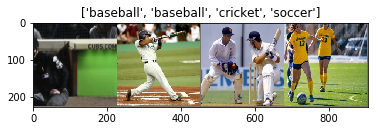

In [65]:
imshow(out, title=[class_names[x] for x in classes])

In [66]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Generic function to display predictions for a few images

In [67]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#### Finetuning the convnet

In [36]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [80]:
# Load a pretrained model and reset final fully connected layer.

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

# Ensuring the model is using GPU
model_ft = model_ft.to(device)

# As we have two classes (0 or 1) we will use cross-entropy as criterion
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


#### Train and evaluate

In [38]:
import time
import os
import copy

In [81]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2364 Acc: 0.4167
val Loss: 0.5238 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.7441 Acc: 0.7222
val Loss: 0.2878 Acc: 0.9048

Epoch 2/24
----------
train Loss: 0.5975 Acc: 0.7361
val Loss: 0.1811 Acc: 0.9206

Epoch 3/24
----------
train Loss: 0.5059 Acc: 0.7917
val Loss: 0.2725 Acc: 0.8571

Epoch 4/24
----------
train Loss: 0.4445 Acc: 0.8333
val Loss: 0.1863 Acc: 0.9365

Epoch 5/24
----------
train Loss: 0.4757 Acc: 0.8194
val Loss: 0.1587 Acc: 0.9206

Epoch 6/24
----------
train Loss: 0.6598 Acc: 0.7639
val Loss: 0.1751 Acc: 0.9524

Epoch 7/24
----------
train Loss: 0.2931 Acc: 0.8889
val Loss: 0.1952 Acc: 0.9048

Epoch 8/24
----------
train Loss: 0.3239 Acc: 0.8472
val Loss: 0.1869 Acc: 0.9048

Epoch 9/24
----------
train Loss: 0.2912 Acc: 0.8889
val Loss: 0.2024 Acc: 0.9048

Epoch 10/24
----------
train Loss: 0.2376 Acc: 0.9236
val Loss: 0.1991 Acc: 0.9365

Epoch 11/24
----------
train Loss: 0.3173 Acc: 0.8819
val Loss: 0.1689 Acc: 0.8889

Ep

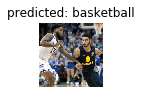

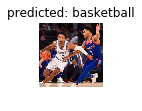

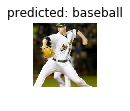

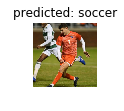

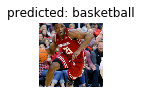

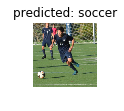

In [82]:
visualize_model(model_ft)

In [83]:
model_ft.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [84]:
model_ft.named_parameters

<bound method Module.named_parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [87]:
model_ft.fc

Linear(in_features=512, out_features=4, bias=True)